In [1]:
import glob
import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

tissue = 'PB'
mpl.rcParams.update(params)
sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='figures/QCandAnnotation/{}'.format(tissue)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

In [2]:
%run ../_helper.py

In [3]:
data_path = "/home/michaelswift/repos/shared_data/pipeline_outs/"
for file in glob.glob(data_path+"*"):
    print(file)
    # do the routine:
    # load data
    if tissue in file:
        adata = sc.read_h5ad(file)
        # remove IGH and IGL variable genes from highly variable genes for clustering analysis 
        adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV|FOS|JUN|HSP|RPL"), 'highly_variable'] = False
        # ad hoc exclusion of weird samples
        adata = adata[adata.obs.sample_uid != 'TBd3_fresh_B200']
        adata = cluster(adata, batch_correct=False)
        filter_low_abundance_cell_groups = False
        cell_group = "predicted_labels"
        if filter_low_abundance_cell_groups:
            select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
            adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
        

/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_LN.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_PB.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/swift_etal.h5ad
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_BM.h5ad.gz
PCA-ing
drawing neighbor graph
UMAP-ing
leiden-ing
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_subsampled.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/web_summary
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_SP.h5ad.gz


In [4]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=False)
adata = predictions.to_adata(prefix="High_Res_")
# not sure why this isn't added automatically
adata.uns['log1p'] = {"base":np.e}


predictions = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting=False)
adata = predictions.to_adata(prefix="Low_Res_")
# not sure why this isn't added automatically
adata.uns['log1p'] = {"base":np.e}

🔬 Input data has 68935 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 68935 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [5]:
filter_low_abundance_cell_groups = False
cell_group = "predicted_labels"
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
adata.obs['predicted_labels'].cat.remove_unused_categories(inplace=True)

## Doublet Detection

In [6]:
import scrublet as scr

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 12.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 151.3 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 8.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.6%
Elapsed time: 153.7 seconds


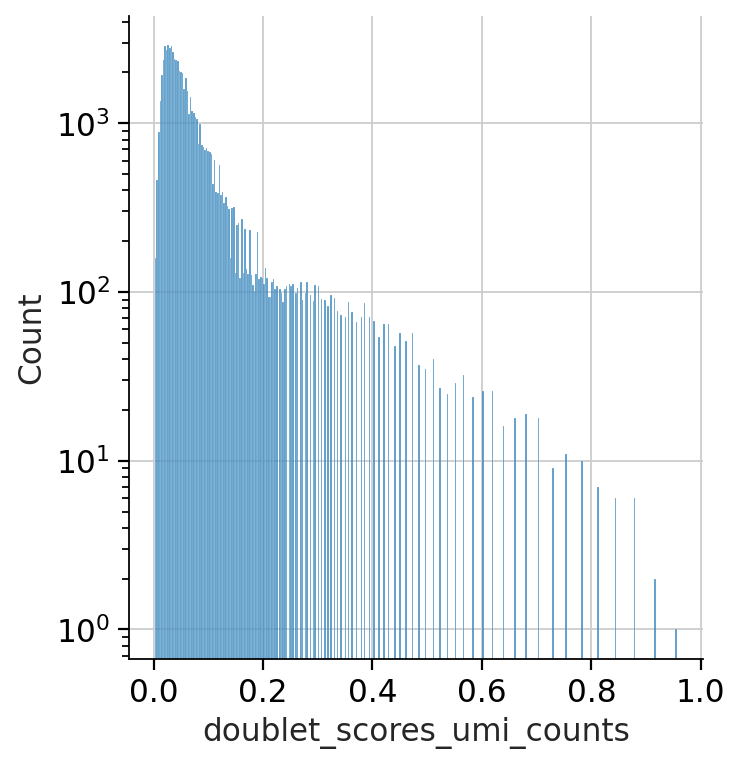

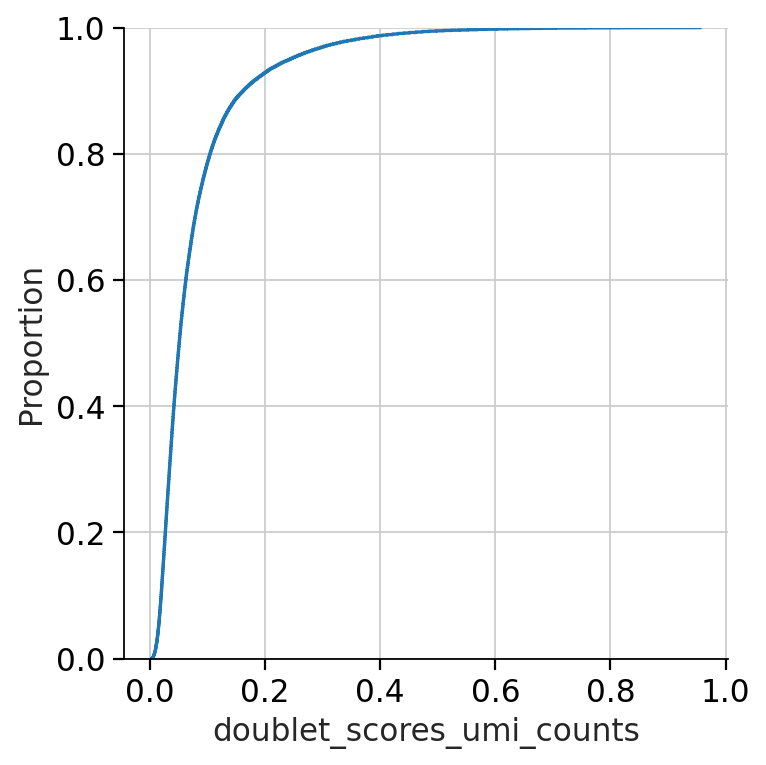

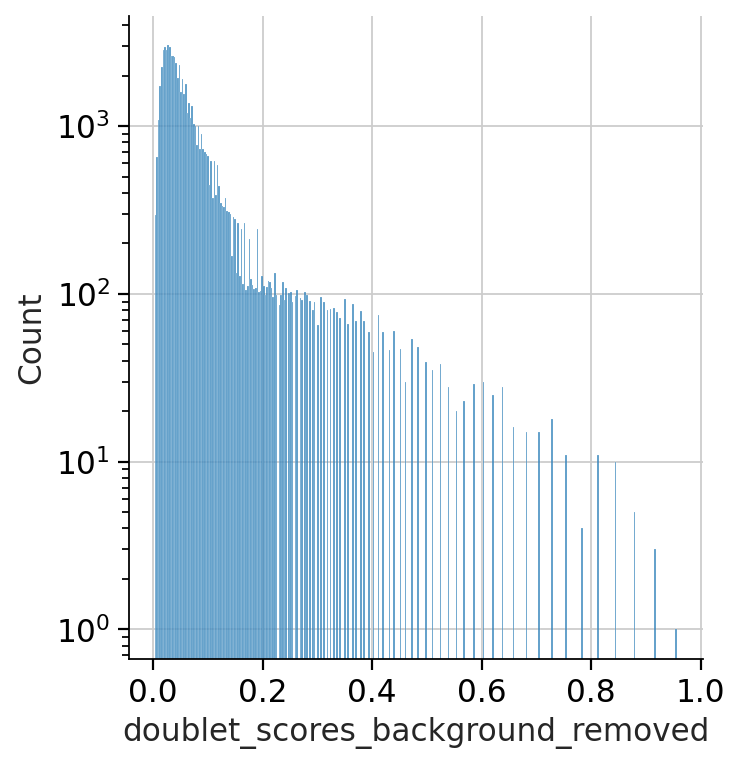

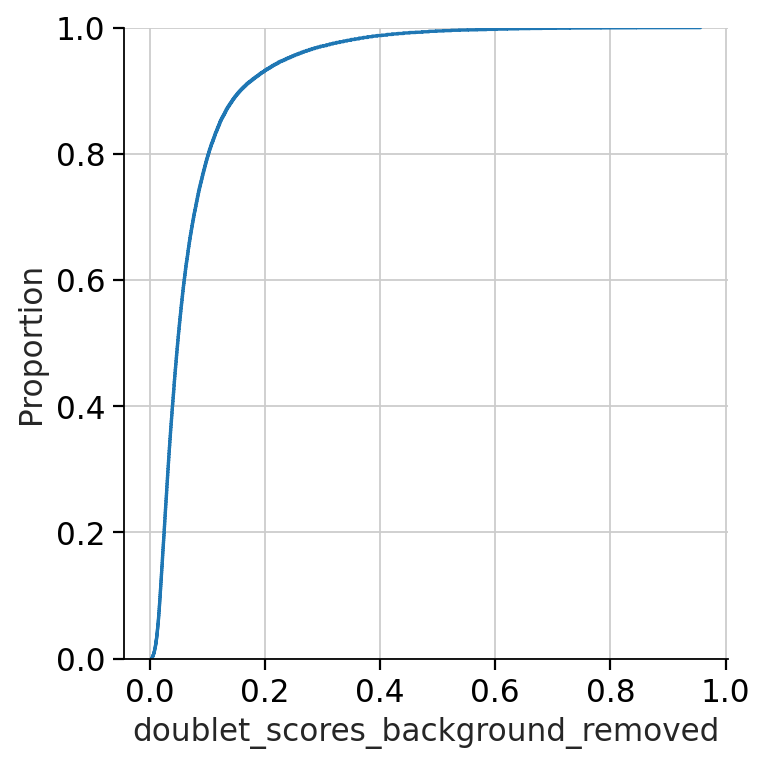

In [7]:
for layer in ['umi_counts', 'background_removed']: 
    scrub = scr.Scrublet(adata.to_df(layer=layer))
    prediction = 'predicted_doublets_{}'.format(layer)
    score = 'doublet_scores_{}'.format(layer)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata.obs.loc[:, score] = doublet_scores 
    adata.obs.loc[:,prediction] = predicted_doublets
    # modify predicted doublets based on manual score cutoff
    sns.displot(data = adata.obs, x = score)
    plt.yscale('log')
    sns.displot(data = adata.obs, x = score, kind = 'ecdf')
    adata.obs.loc[:,prediction] = adata.obs[score] > 0.2
    adata.obs.loc[:,prediction] = adata.obs[prediction].astype(str)

... storing 'predicted_doublets_umi_counts' as categorical
... storing 'predicted_doublets_background_removed' as categorical


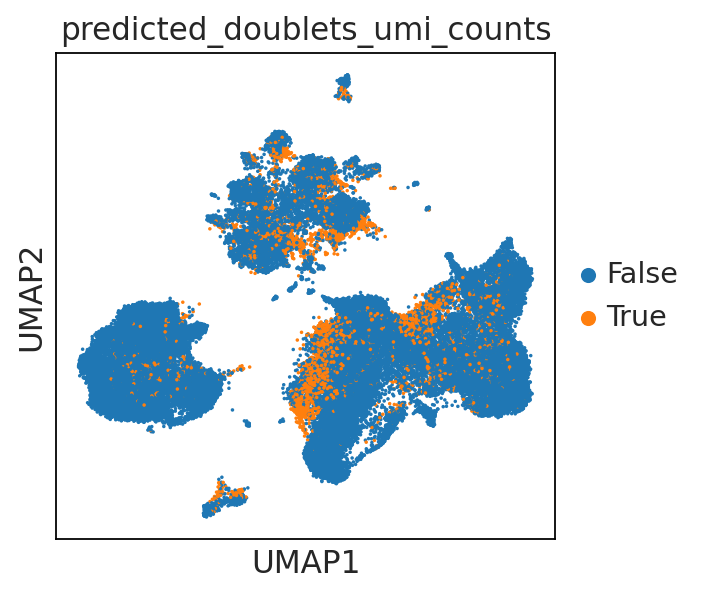

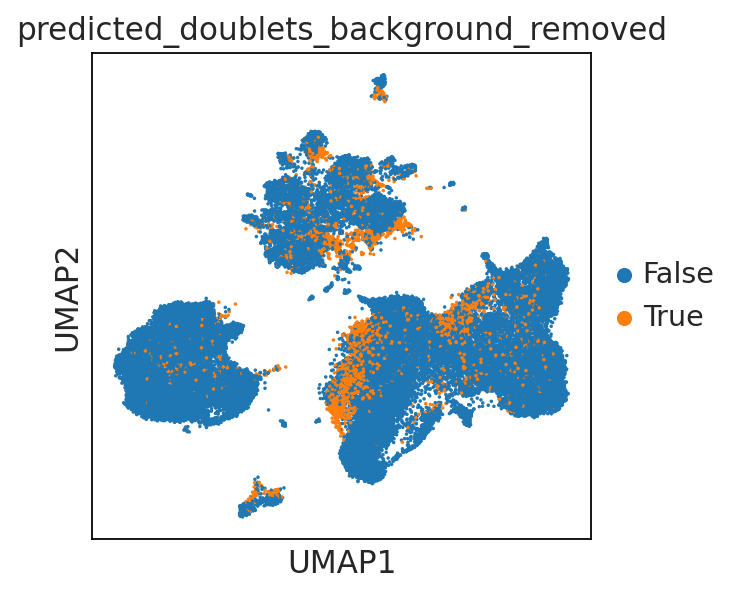

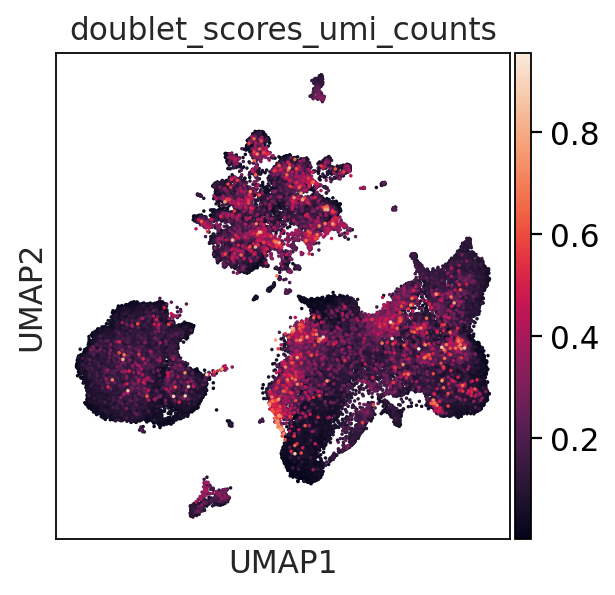

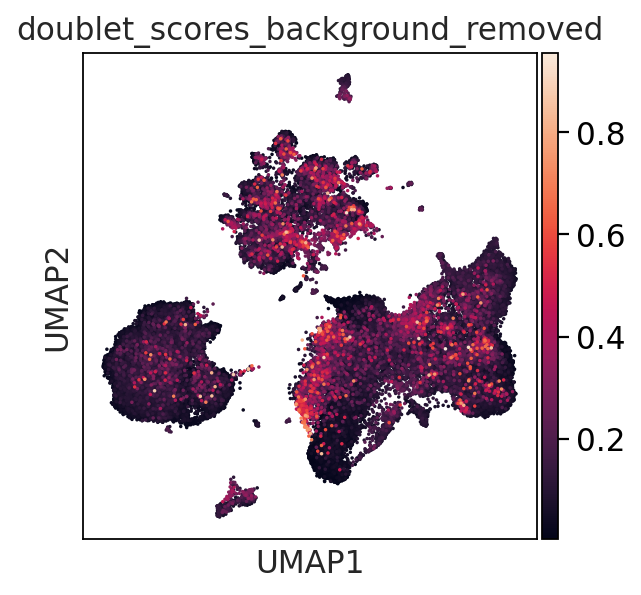

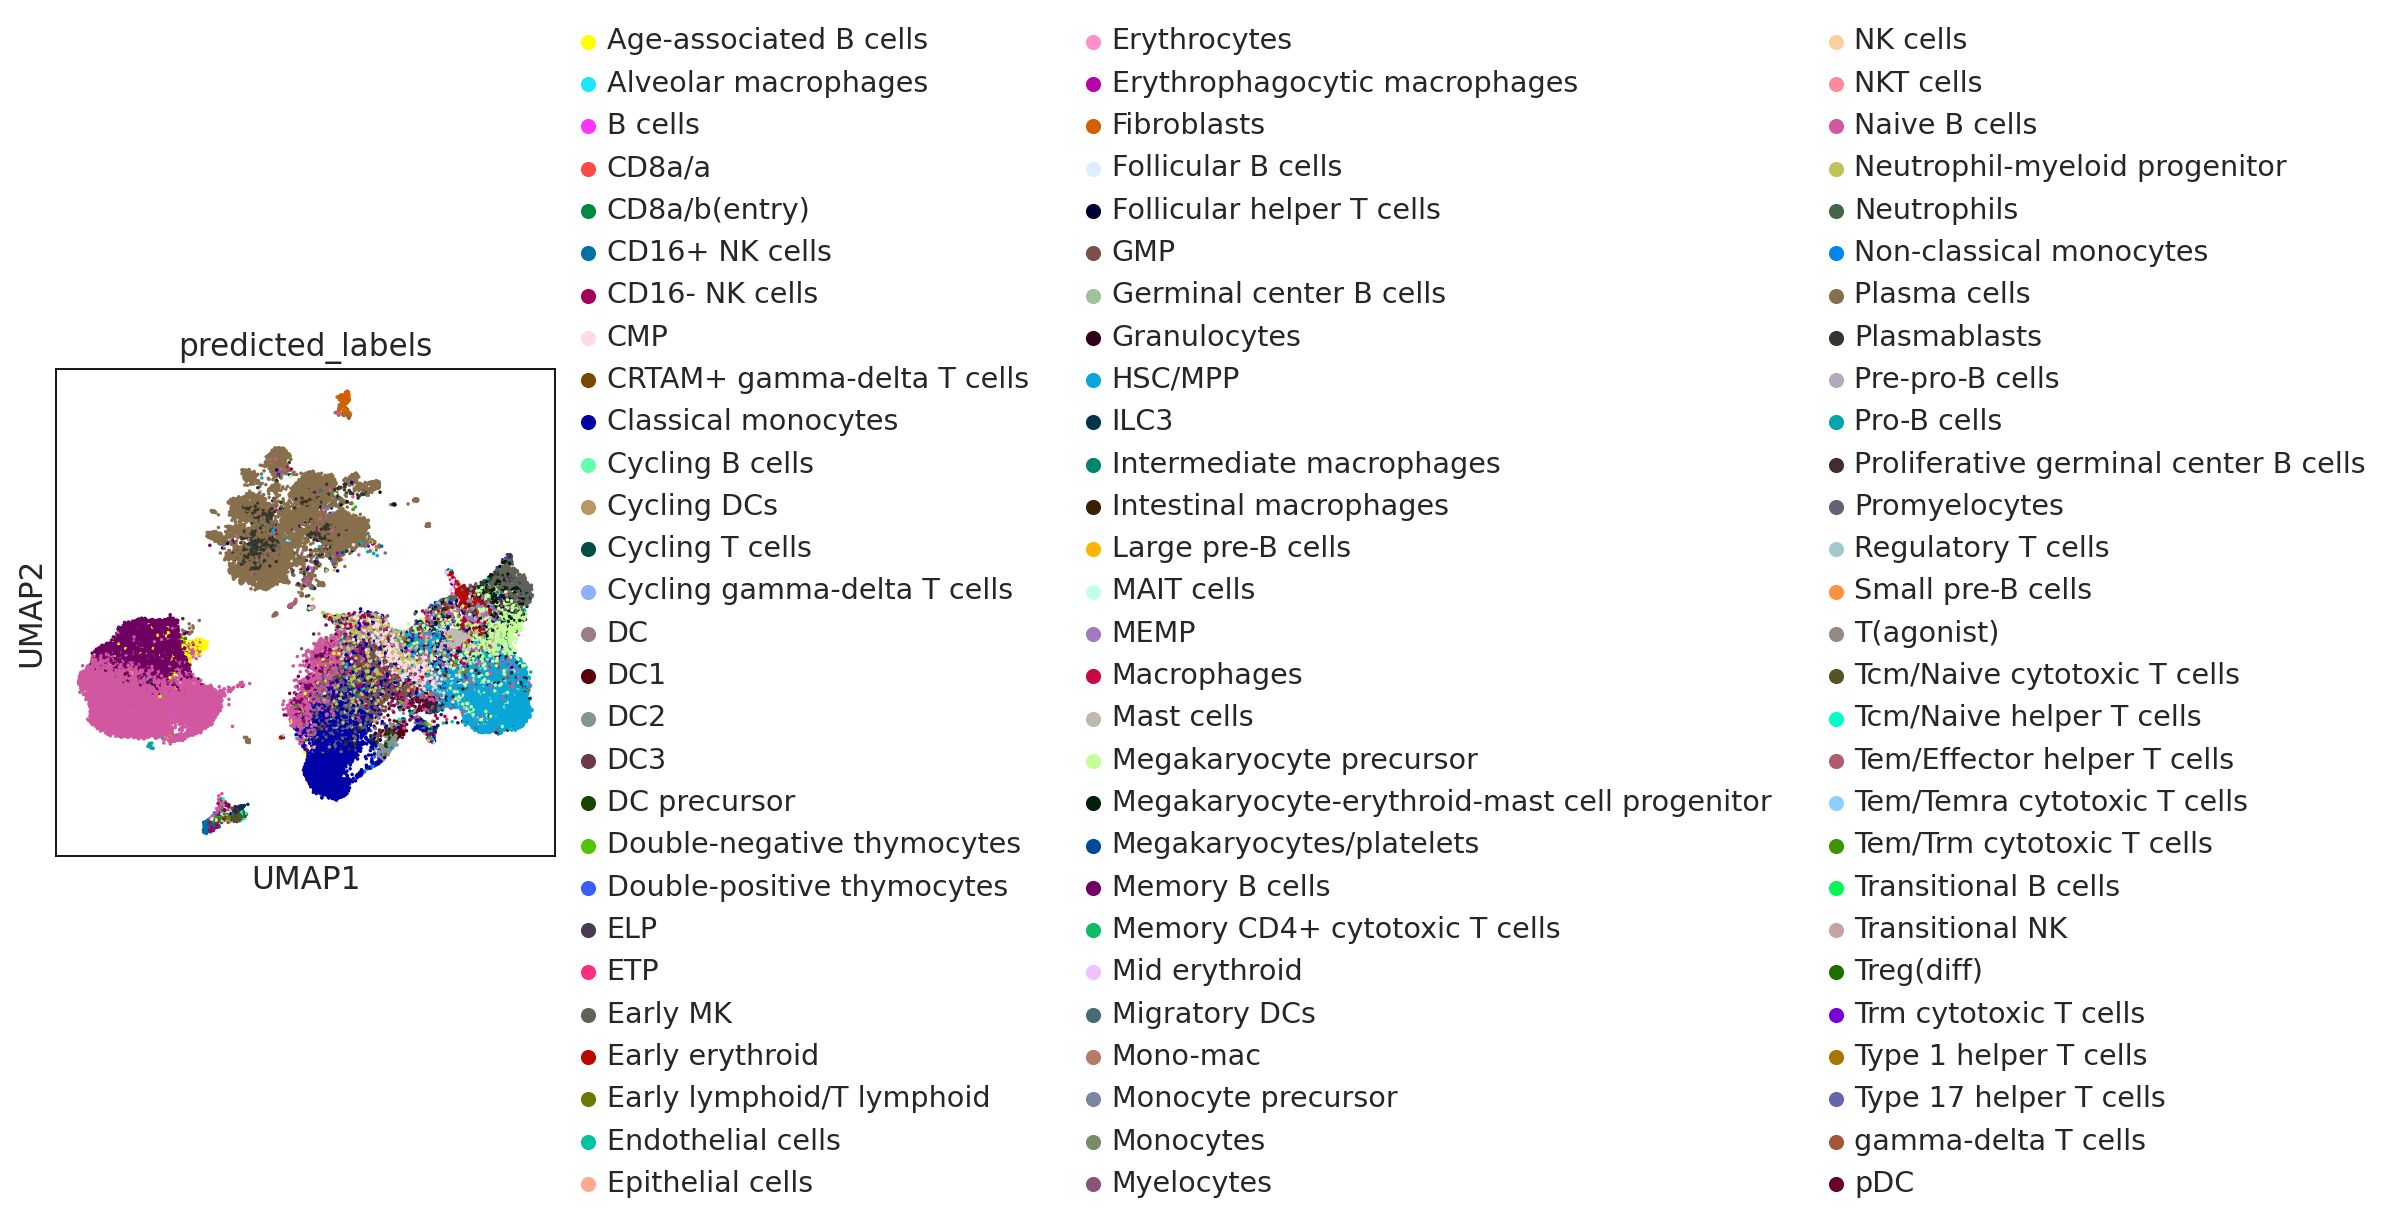

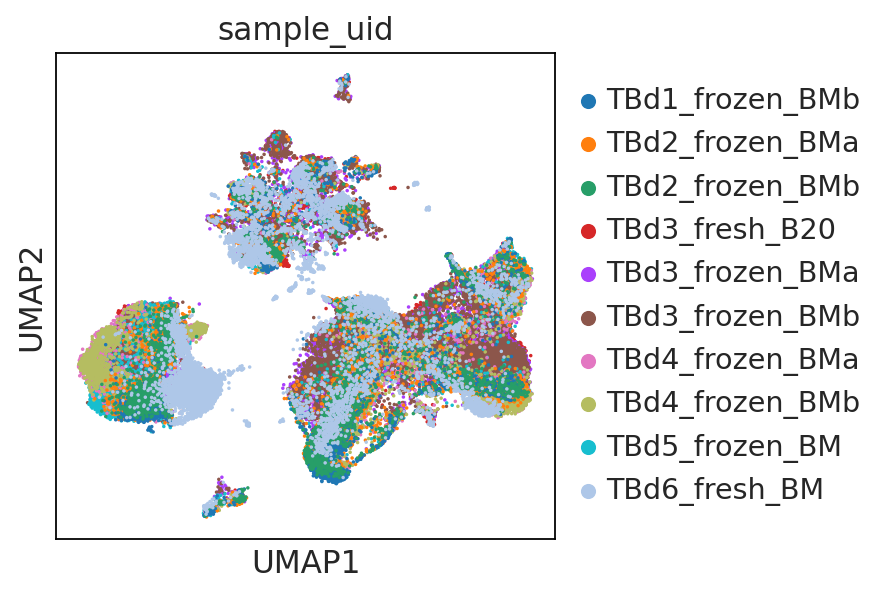

In [8]:
## Technical UMAPs
variables = ['predicted_doublets_umi_counts', 'predicted_doublets_background_removed', 'doublet_scores_umi_counts', 'doublet_scores_background_removed', 'predicted_labels', 'sample_uid']
for var in variables:
    sc.pl.umap(adata, color = var, size = 10, save = "{}_{}".format(var, tissue))

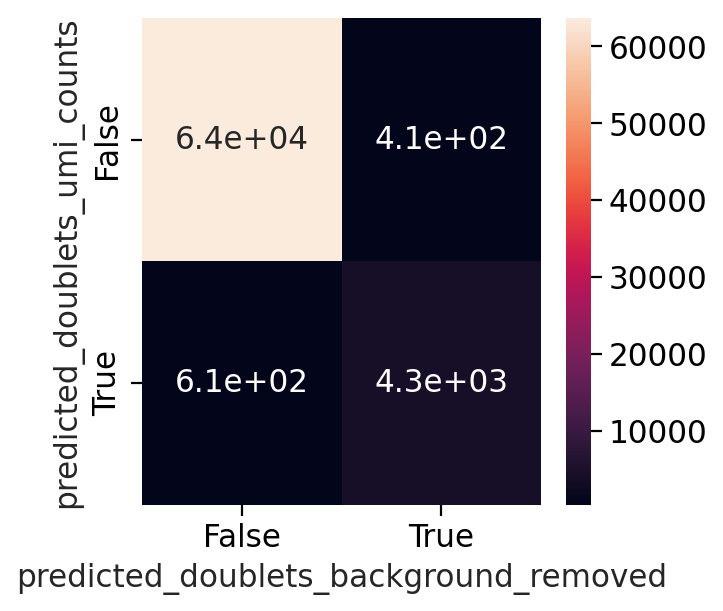

In [12]:
g = sns.heatmap(sc.metrics.confusion_matrix('predicted_doublets_umi_counts', 'predicted_doublets_background_removed', adata.obs, normalize=False), annot=True)

In [14]:
save_figure(g.figure, "confusion_matrix")

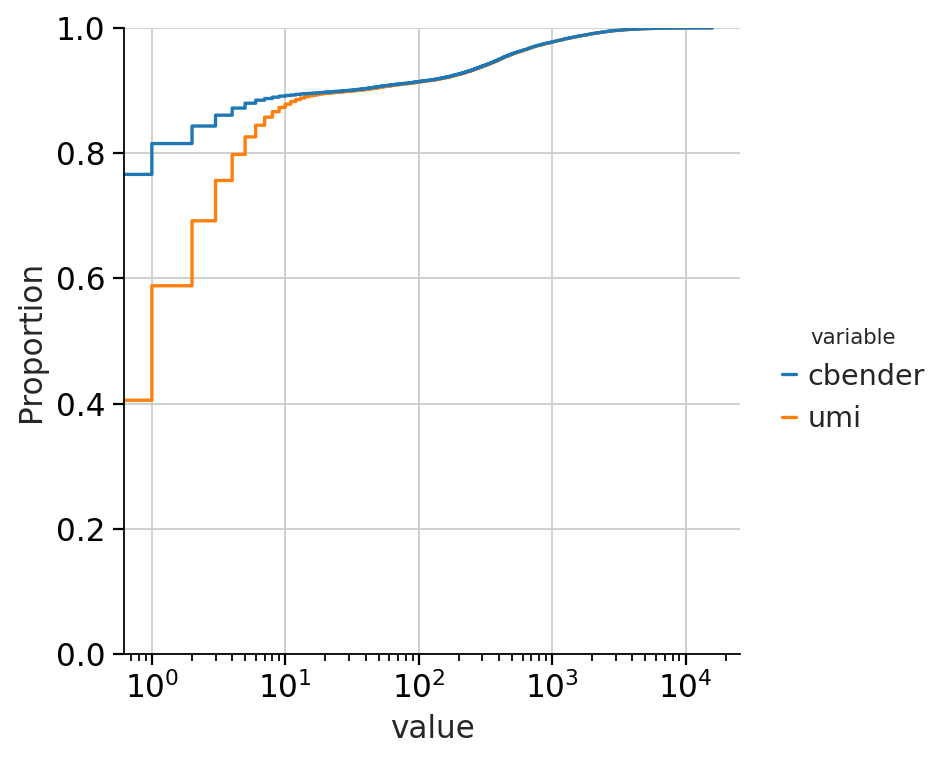

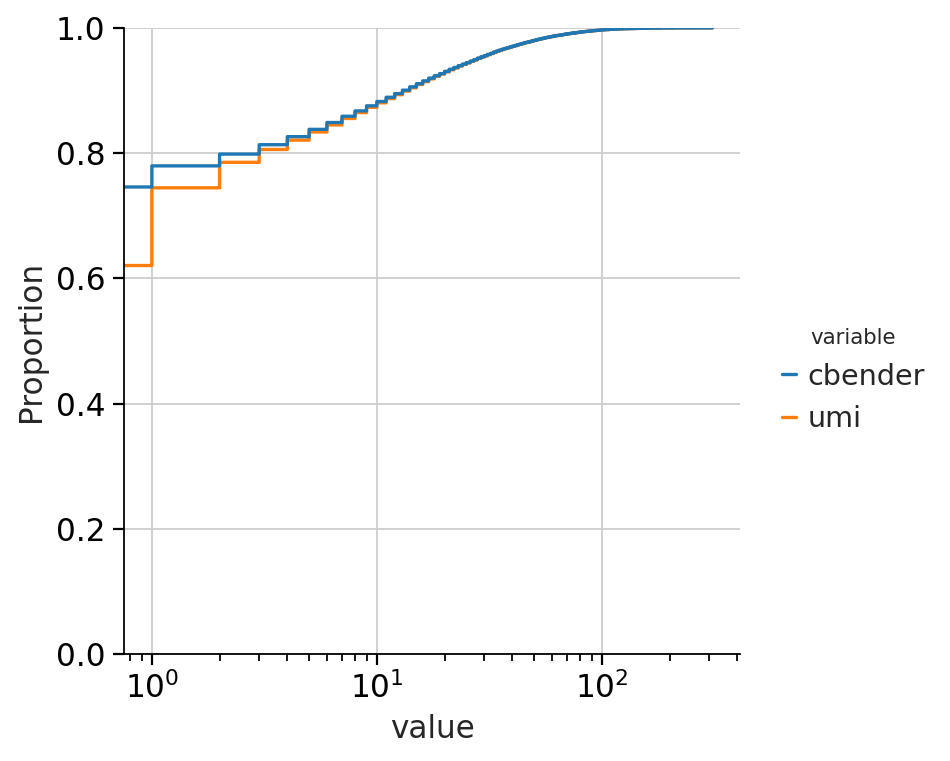

In [ ]:
gene = "IGKC"
_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')
data = pd.concat([_bg, _umi], axis=1
data.columns = ['cbender', 'umi']
data = data.melt()
sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)
save_figure(g.figure, "{}_bg_remove".format(gene))

gene = "AZU1"
_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')
data = pd.concat([_bg, _umi], axis=1
data.columns = ['cbender', 'umi']
data = data.melt()
sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)
save_figure(g.figure, "{}_bg_remove".format(gene))
                 
gene = "IL7R"
_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')
data = pd.concat([_bg, _umi], axis=1
data.columns = ['cbender', 'umi']
data = data.melt()
sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)
save_figure(g.figure, "{}_bg_remove".format(gene))

In [15]:
sc.tl.leiden(adata, key_added='{}_leiden'.format(tissue))

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_gene

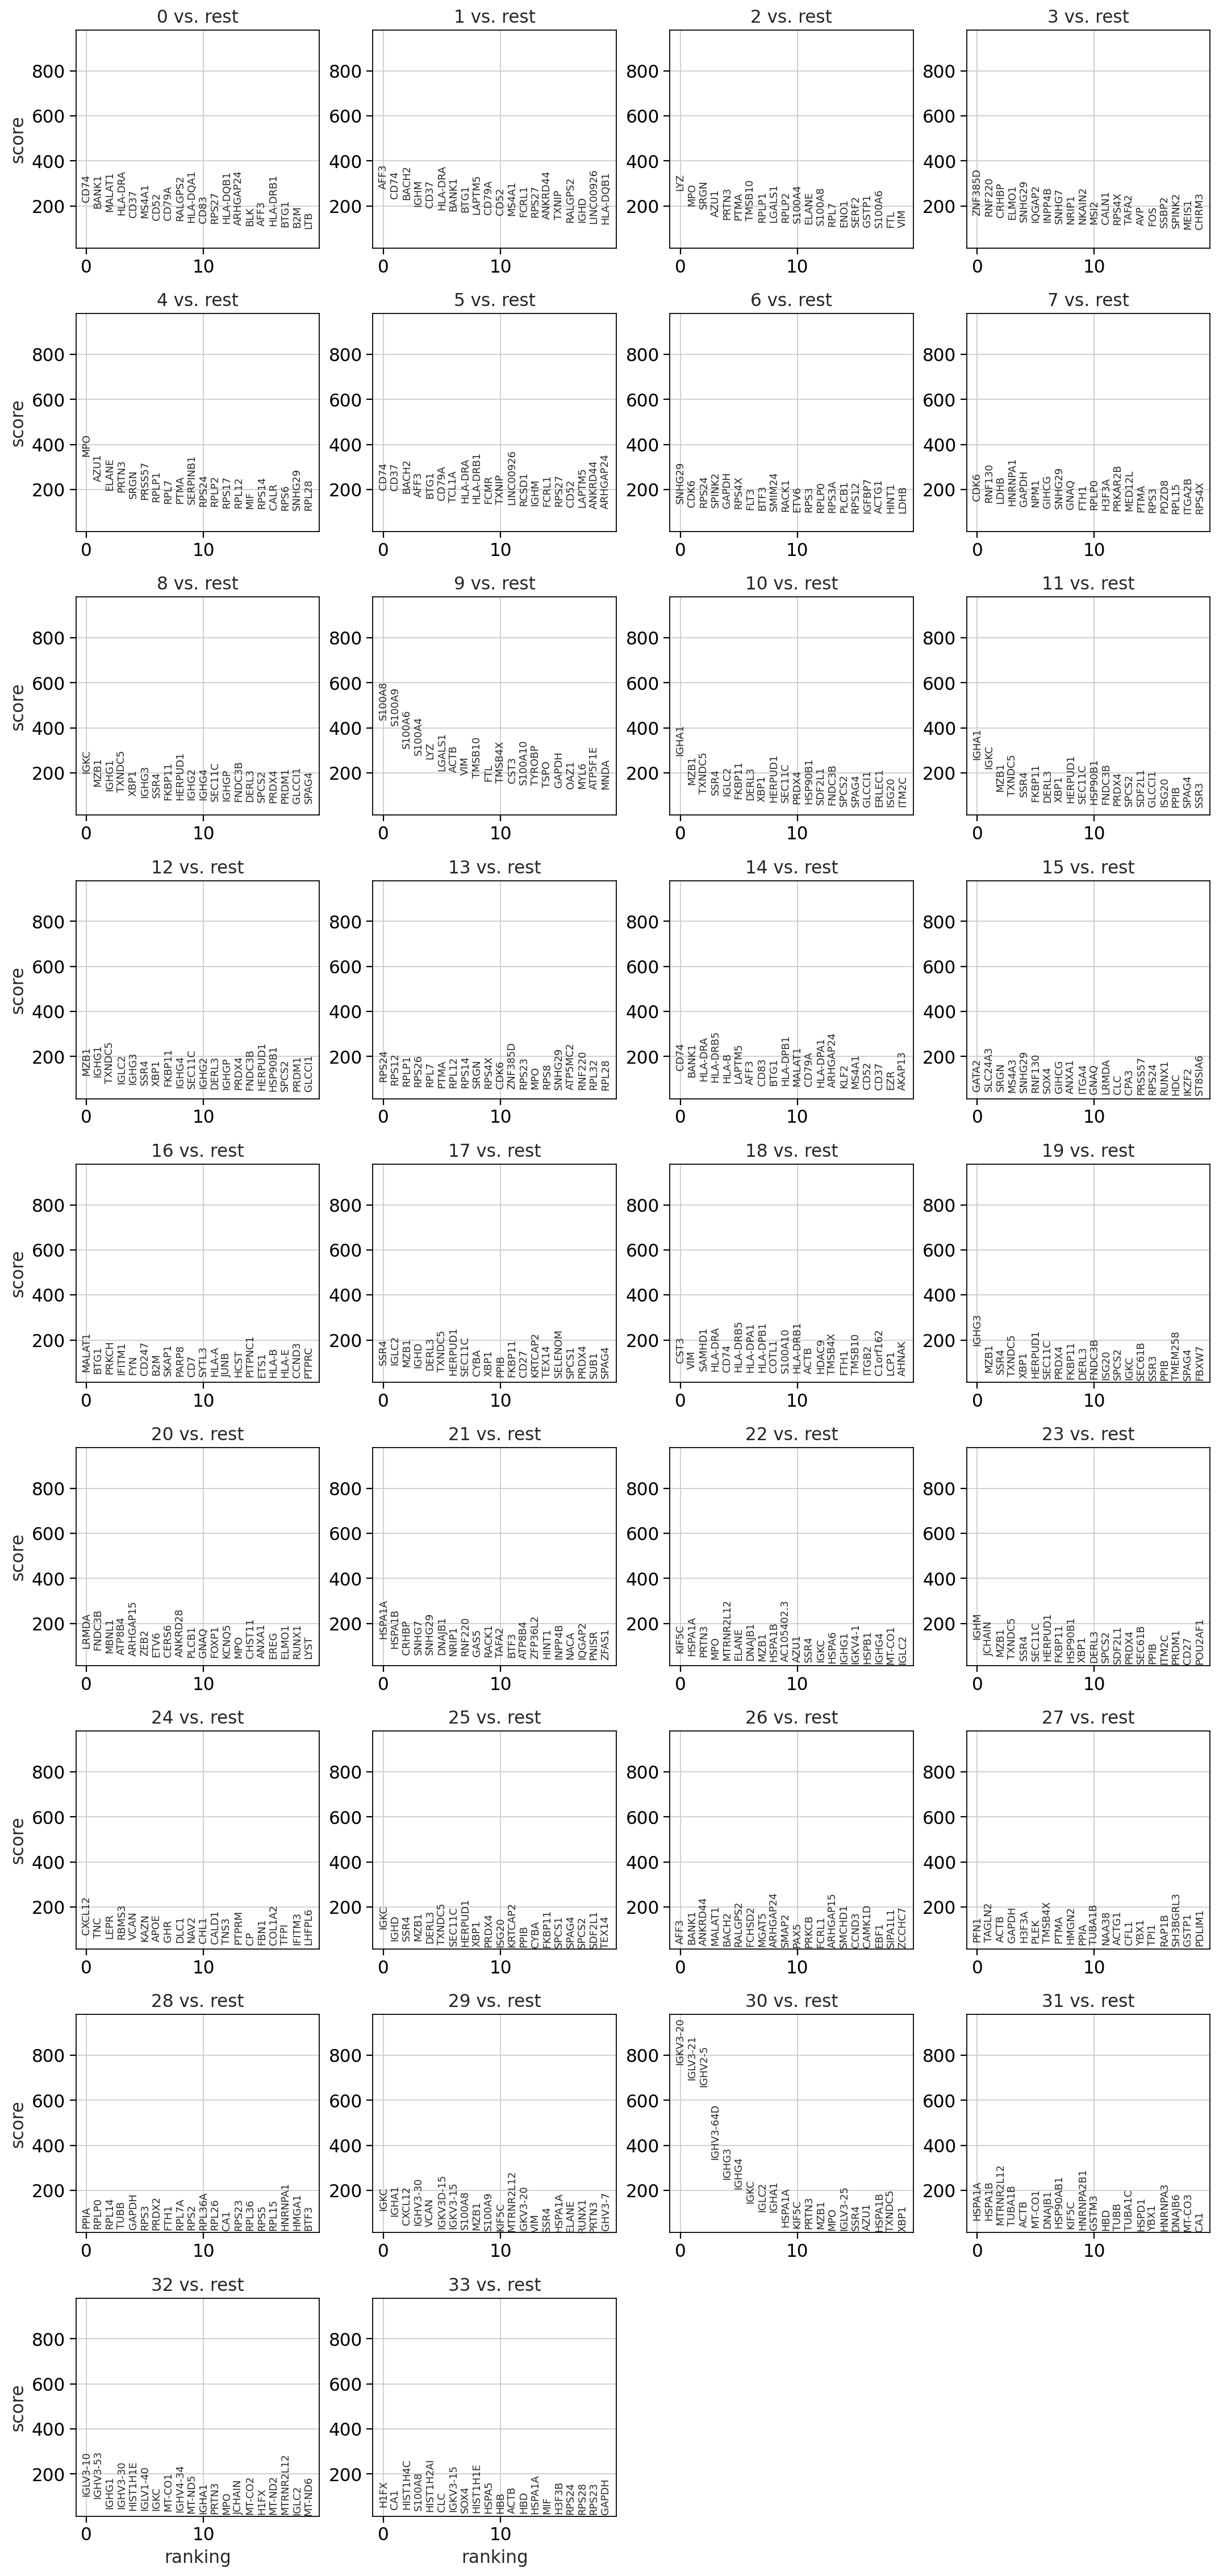

In [16]:
sc.tl.rank_genes_groups(adata, groupby='{}_leiden'.format(tissue))
sc.pl.rank_genes_groups(adata)

In [20]:
adata.obs['High_Respredicted_labels'].value_counts()

Naive B cells          19813
Plasma cells           10547
HSC/MPP                 7378
Memory B cells          6547
Classical monocytes     6516
                       ...  
Cycling DCs                1
Follicular B cells         1
T(agonist)                 1
Large pre-B cells          1
Pre-pro-B cells            1
Name: High_Respredicted_labels, Length: 84, dtype: int64

In [22]:
adata.obs['doublet_scores_umi_counts']

AAACCTGAGCCAACAG-1      0.023119
AAACCTGAGGACAGCT-1-1    0.052885
AAACCTGAGTCAAGCG-1      0.034283
AAACCTGAGTGACATA-1      0.030888
AAACCTGCACCGAAAG-1      0.034637
                          ...   
TTTGTCATCTCCAACC-1-1    0.115369
TTTGTCATCTCCCTGA-1-2    0.189093
TTTGTCATCTCTGCTG-1-1    0.018728
TTTGTCATCTGTTGAG-1-1    0.145793
TTTGTCATCTTTACGT-1      0.031880
Name: doublet_scores_umi_counts, Length: 68935, dtype: float64

In [21]:
df = adata.obs[['sample_uid', 'High_Res_predicted_labels', "Low_Res_predicted_labels', 'conf_score', 'doublet_scores_umi_counts', 'predicted_doublets_umi_counts', 'n_genes', 'total_counts', 'total_counts_mt', '{}_leiden'.format(tissue), 'tissue', ]]

KeyError: "['doulet_scores_umi_counts'] not in index"

In [ ]:
df.to_csv('{}_obs.tab'.format(tissue), sep = '\t')

## Filter Leiden groups which appear to be other celltypes

In [ ]:
data = pd.DataFrame(adata.obs.groupby('sample_uid').B_cell.value_counts(normalize = True))

In [ ]:
data.columns = ['fraction_b_cells']

In [ ]:
data = data.reset_index()

In [ ]:
data[data.B_cell]

In [ ]:
file_name = "{}_bcell_fraction.tab".format(tissue)
data.to_csv(file_name, sep = '\t')

In [ ]:
cell_group = 'leiden'
bcells = adata[adata.obs[cell_group].isin(['0', '2', '5', '6'])]
